<a href="https://colab.research.google.com/github/samarranjit/Yield_Prediction/blob/main/Deep_Learning_Techniques/Narrowing_down_on_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working on narrowing down the variables that we have
Right now , the variables are highly correlated with each other, have high dimension but still have low predictability on the yield so let's try to improve this


### Importing pacakges and the variables


In [ ]:
%cd Yield_Prediction/


/home/cholab/LabMembers/Samar/Yield_Prediction


/home/cholab/LabMembers/Samar/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
!uv add xgboost

Resolved 175 packages in 290ms
Prepared 1 package in 1.48s
Installed 1 package in 14ms
 + xgboost==3.1.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# soy_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_soybeans_absolute_all_years_with_divided_precipitation.parquet"
# corn_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_corn_absolute_all_years_with_divided_precipitation.parquet"
# wheat_fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_wheat_absolute_all_years_with_divided_precipitation2.parquet"
soy_fn = r"data/df_soybeans_absolute_all_years_with_divided_precipitation.parquet"
corn_fn = r"data/df_corn_absolute_all_years_with_divided_precipitation.parquet"
wheat_fn = r"data/df_wheat_absolute_all_years_with_divided_precipitation2.parquet"

df_soybeans = pd.read_parquet(soy_fn)
df_corn = pd.read_parquet(corn_fn)
df_wheat = pd.read_parquet(wheat_fn)

print(df_soybeans.describe())
print(df_corn.describe())
print(df_wheat.describe())

                   x             y          yield           year  \
count  611315.000000  6.113150e+05  611315.000000  611315.000000   
mean   337339.638666  4.321327e+06      46.694985    2019.207328   
std      2571.816114  8.672437e+02      16.998010       2.978032   
min    330893.532259  4.318616e+06       4.139045    2014.000000   
25%    336099.599602  4.320616e+06      34.509420    2017.000000   
50%    336840.073515  4.321341e+06      46.845428    2019.000000   
75%    339214.129061  4.321947e+06      59.010979    2022.000000   
max    342733.656286  4.323242e+06     116.790192    2024.000000   

           ndvi_mean       ndvi_max     ndvi_range   lst_median_k  \
count  611315.000000  611315.000000  611315.000000  611315.000000   
mean        0.546852       0.867373       0.598420     301.906139   
std         0.084386       0.079921       0.153782       3.212771   
min         0.253719       0.324230       0.000000     289.562653   
25%         0.493608       0.840899       

### Cleaning dataset

In [ ]:
df_soybeans = df_soybeans[df_soybeans['gi_max'] < df_soybeans['gi_max'].quantile(0.98)]
df_wheat = df_wheat[df_wheat['gi_max'] < df_wheat['gi_max'].quantile(0.98)]
df_corn = df_corn[df_corn['gi_max'] < df_corn['gi_max'].quantile(0.98)]

In [ ]:
df_wheat = df_wheat[(df_wheat["yield"] < df_wheat["yield"].quantile(0.98)) & (df_wheat["yield"] > df_wheat["yield"].quantile(0.02))]
df_soybeans = df_soybeans[(df_soybeans["yield"] < df_soybeans["yield"].quantile(0.98)) & (df_soybeans["yield"] > df_soybeans["yield"].quantile(0.02))]
df_corn = df_corn[(df_corn["yield"] < df_corn["yield"].quantile(0.98)) & (df_corn["yield"] > df_corn["yield"].quantile(0.02))]

In [ ]:
df = df_wheat.copy()
df['elevation_squared'] = df['elevation'] ** 2
df['slope_squared'] = df['slope'] ** 2
df['elev_slope'] = df['elevation'] * df['slope']
df['elev_aspect'] = df['elevation'] * df['aspect']
df['slope_aspect'] = df['slope'] * df['aspect']


df['ndvi_pr'] = df['ndvi_mean'] * df['pr_season_mm']

df['aspect_southness'] = 1 - np.abs((df['aspect'] - 180) / 180)
df.info()

df_wheat = df.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 173073 entries, 262 to 21167
Data columns (total 64 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   x                       173073 non-null  float64
 1   y                       173073 non-null  float64
 2   yield                   173073 non-null  float64
 3   field                   173073 non-null  object 
 4   year                    173073 non-null  int64  
 5   elevation               173073 non-null  float32
 6   slope                   173073 non-null  float32
 7   aspect                  173073 non-null  float32
 8   ndvi_mean               173073 non-null  float64
 9   ndvi_max                173073 non-null  float64
 10  ndvi_range              173073 non-null  float64
 11  lst_median_k            173073 non-null  float64
 12  lst_range_k             173073 non-null  float64
 13  lst_max_k               173073 non-null  float64
 14  pr_season_mm            

### Getting a subset of dataset

In [ ]:
# ==== SIMPLE SAMPLER (run this first) ====
import numpy as np
import pandas as pd

# ---- USER KNOBS (edit these) ----
SEED = 42
TARGET_COL = "yield"
FIELD_COL  = "field"
YEAR_COL   = "year"

SAMPLE_SIZE_TARGET = 50_000   # typical: 50k (try 80k–100k if you have resources)
MIN_PER_GROUP      = 130      # ensure coverage per field×year
MAX_PER_GROUP      = 1000     # avoid domination by big groups
BASE_FRAC          = 0.10     # start by taking ~10% from each group
# --------------------------------

rng = np.random.default_rng(SEED)
df = df_soybeans.copy()

# Build group key
df["field_year"] = df[FIELD_COL].astype(str) + "_" + df[YEAR_COL].astype(str)

# Group sizes and initial allocation
gsize = df.groupby("field_year").size()
alloc = np.ceil(gsize * BASE_FRAC).astype(int)
alloc = alloc.clip(lower=MIN_PER_GROUP, upper=MAX_PER_GROUP)
alloc = np.minimum(alloc, gsize)  # cannot exceed what's available

# Simple adjuster to match SAMPLE_SIZE_TARGET (no fancy math; easy to read)
def adjust_allocation_simple(alloc, target, gsize, min_k, max_k):
    alloc = alloc.copy()
    total = int(alloc.sum())

    # Scale DOWN by peeling 1 at a time from the largest groups (above min_k)
    while total > target:
        # candidates that can give 1 back
        can_give = alloc[alloc > min_k]
        if can_give.empty:
            break
        idx = can_give.sort_values(ascending=False).index[0]
        alloc.loc[idx] -= 1
        total -= 1

    # Scale UP by adding 1 at a time to groups with headroom
    while total < target:
        headroom = (np.minimum(max_k, gsize) - alloc)
        can_take = headroom[headroom > 0]
        if can_take.empty:
            break
        # give to the group currently smallest (for balance)
        idx = (alloc.loc[can_take.index]).sort_values(ascending=True).index[0]
        alloc.loc[idx] += 1
        total += 1

    return alloc

alloc = adjust_allocation_simple(
    alloc=alloc,
    target=SAMPLE_SIZE_TARGET,
    gsize=gsize,
    min_k=MIN_PER_GROUP,
    max_k=MAX_PER_GROUP
)

# Draw samples per group (reproducible)
sampled_parts = []
for gy, k in alloc.items():
    if k <= 0:
        continue
    gdf = df[df["field_year"] == gy]
    sampled_parts.append(gdf.sample(n=int(k), random_state=SEED, replace=False))

sampled_tuning_set = pd.concat(sampled_parts, ignore_index=True)

# Quick report
total_groups = df["field_year"].nunique()
covered_groups = sampled_tuning_set["field_year"].nunique()
per_group_counts = sampled_tuning_set.groupby("field_year").size()

print("=== Sampling Summary ===")
print(f"Requested size: {SAMPLE_SIZE_TARGET:,}")
print(f"Actual size:    {len(sampled_tuning_set):,}")
print(f"Groups covered: {covered_groups}/{total_groups} "
      f"({covered_groups/total_groups*100:.1f}%)")
print(f"Median per-group sample: {int(per_group_counts.median())}")

# Keep only what we need going forward (optional but tidy)
# sampled_tuning_set now holds your training sample for cell 2.


=== Sampling Summary ===
Requested size: 50,000
Actual size:    50,075
Groups covered: 386/386 (100.0%)
Median per-group sample: 130


In [ ]:
df_soybeans_copy = df_soybeans.copy()
df_soybeans = sampled_tuning_set.copy()

In [ ]:
!uv add tabulate

Resolved 174 packages in 256ms
Prepared 1 package in 44ms
Installed 1 package in 14ms
 + tabulate==0.9.0


In [ ]:
df_soybeans.keys()

Index(['x', 'y', 'yield', 'field', 'year', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max',
       'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max',
       'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
       'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope',
       'aspect', 'elevation_squared', 'slope_squared', 'elev_slope',
       'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness',
       'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day',
       'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity',
       'spring_pr_max_mm_day', 'spring_pr_mean_mm_day',
       'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity',
       'summer_pr_max_mm_day', 'summer_pr_mean_mm_day',
       'summer_pr_range_mm

Original data shape: (50075, 60)
Original features: ['x', 'y', 'field', 'year', 'ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k', 'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day', 'aridity', 'theta_s', 'clay_pct', 'ksat', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope', 'aspect', 'elevation_squared', 'slope_squared', 'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness', 'fall_aridity', 'fall_pr_max_mm_day', 'fall_pr_mean_mm_day', 'fall_pr_range_mm_day', 'fall_pr_season_mm', 'spring_aridity', 'spring_pr_max_mm_day', 'spring_pr_mean_mm_day', 'spring_pr_range_mm_day', 'spring_pr_season_mm', 'summer_aridity', 'summer_pr_max_mm_day', 'summer_pr_mean_mm_day', 'summer_pr_range_mm_day', 'summer_pr_season_mm', 'field_year']

Training feature

/tmp/ipykernel_1657679/2909121478.py:85: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(pcs, np.cumsum(pc_variance), 'r-o', marker='o')


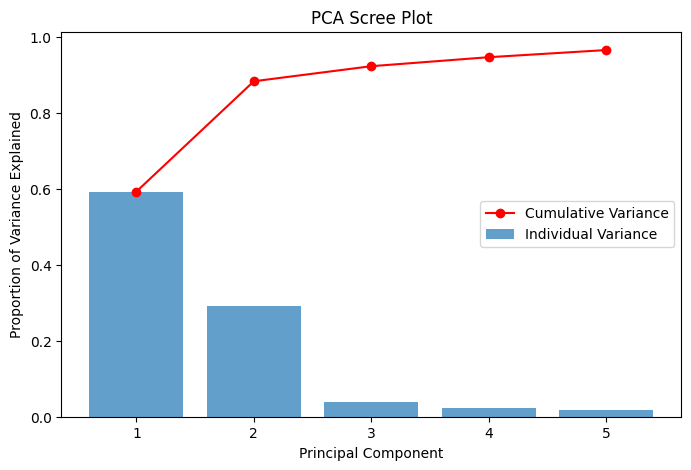


--- Model Training ---
Model trained on PCA components.

--- Model Evaluation ---
Root Mean Squared Error (RMSE): 13.7310
R-squared (R²): 0.2827

--- PCA Component Loadings ---
|            |   PC1 |    PC2 |    PC3 |    PC4 |    PC5 |
|:-----------|------:|-------:|-------:|-------:|-------:|
| ndvi_mean  | 0.137 |  0.477 |  0.063 |  0.101 |  0.223 |
| ndvi_max   | 0.344 | -0.034 |  0.244 |  0.171 |  0.642 |
| ndvi_range | 0.280 | -0.312 |  0.088 |  0.129 |  0.420 |
| evi_mean   | 0.227 |  0.403 | -0.117 |  0.227 | -0.058 |
| evi_max    | 0.348 | -0.062 | -0.221 |  0.502 | -0.297 |
| evi_range  | 0.330 | -0.199 | -0.180 |  0.383 | -0.290 |
| gi_mean    | 0.240 |  0.378 | -0.102 | -0.320 | -0.111 |
| gi_max     | 0.347 | -0.066 | -0.379 | -0.424 |  0.075 |
| gi_range   | 0.341 | -0.131 | -0.371 | -0.374 |  0.064 |
| ndwi_mean  | 0.142 |  0.476 |  0.097 |  0.030 | -0.024 |
| ndwi_max   | 0.326 |  0.051 |  0.609 | -0.180 | -0.292 |
| ndwi_range | 0.287 | -0.272 |  0.402 | -0.195 | -0.27

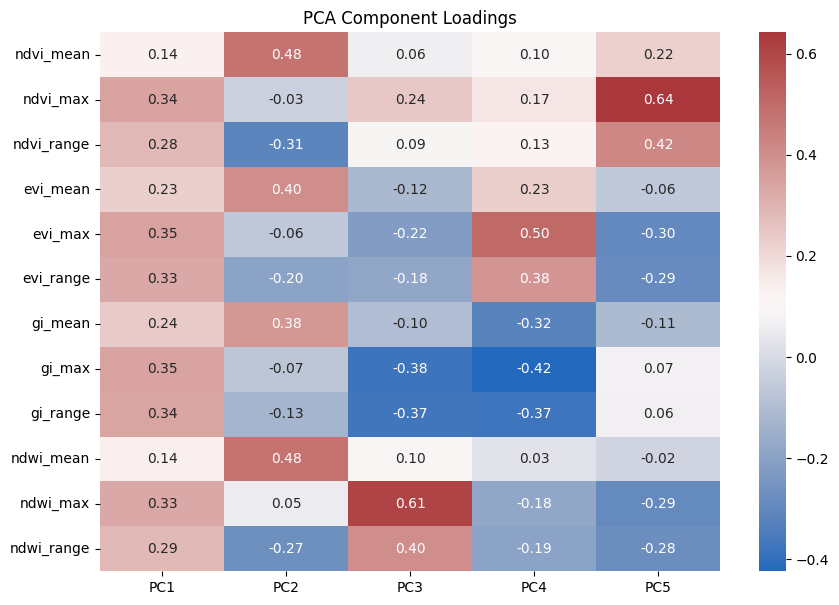

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
# This is a placeholder. Replace 'your_dataset.csv' with your file.
# We'll create a synthetic dataset for this example.
# Let's assume 'yield' is our target and the rest are features.

df = df_soybeans.copy()
# Add some correlation for PCA to be useful

print(f"Original data shape: {df.shape}")
print("Original features:", df.columns.drop('yield').tolist())

# --- 2. Separate Predictors (X) and Target (y) ---
X = df.drop('yield', axis=1)
y = df['yield']

feature_names = [
    'ndvi_mean',
    'ndvi_max',
    'ndvi_range',
    'evi_mean',
    'evi_max',
    'evi_range',
    'gi_mean',
    'gi_max',
    'gi_range',
    'ndwi_mean',
    'ndwi_max',
    'ndwi_range',
    # 'lst_median_k', 'lst_range_k', 'lst_max_k',
    #    'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
    #    'aridity', 'theta_s', 'clay_pct', 'ksat',
    # 'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
    #    'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range', 'elevation', 'slope',
    #    'aspect', 'elevation_squared', 'slope_squared', 'elev_slope',
    #    'elev_aspect', 'slope_aspect', 'ndvi_pr', 'aspect_southness',

]
# --- 3. Train-Test Split ---
# Split data *before* scaling to prevent data leakage from the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. Standardize Predictors ---
# This is critical for PCA!
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
X_train_scaled = scaler.fit_transform(X_train[feature_names])

# Use the same fitted scaler to transform the test data
X_test_scaled = scaler.transform(X_test[feature_names])

print(f"\nTraining features scaled. Mean: {X_train_scaled.mean():.2f}, Std Dev: {X_train_scaled.std():.2f}")

# --- 5. Apply PCA ---
# We specify n_components=0.95 to capture 95% of the variance.
# Alternatively, you could specify an integer (e.g., n_components=3)
pca = PCA(n_components=0.95)

# Fit PCA ONLY on the standardized training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Use the same fitted PCA to transform the test data
X_test_pca = pca.transform(X_test_scaled)

# --- 6. Interpretation: Analyze PCA Results ---
print(f"\nPCA selected {pca.n_components_} components to explain 95% variance.")
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Create a "scree plot"
pc_variance = pca.explained_variance_ratio_
pcs = np.arange(len(pc_variance)) + 1

plt.figure(figsize=(8, 5))
plt.bar(pcs, pc_variance, alpha=0.7)
plt.plot(pcs, np.cumsum(pc_variance), 'r-o', marker='o')
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(pcs)
plt.legend(['Cumulative Variance', 'Individual Variance'])
plt.show()

# --- 7. Train Machine Learning Model ---
# We use the Principal Components (X_train_pca) as our new features.
model = LinearRegression()
model.fit(X_train_pca, y_train)

print("\n--- Model Training ---")
print("Model trained on PCA components.")

# --- 8. Evaluate Model Performance ---
y_pred = model.predict(X_test_pca)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# --- 9. Interpretation: Component Loadings ---
# This helps us understand what each PC represents
# 'pca.components_' rows = PCs, columns = original features
loadings = pd.DataFrame(
    pca.components_.T, # Transpose to make features rows, PCs columns
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=feature_names
)

print("\n--- PCA Component Loadings ---")
print(loadings.to_markdown(floatfmt=".3f"))

# Visualize loadings for the first two PCs
if pca.n_components_ >= 2:
    plt.figure(figsize=(10, 7))
    sns.heatmap(loadings, annot=True, cmap='vlag', fmt='.2f')
    plt.title('PCA Component Loadings')
    plt.show()

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score


def run_pca_yield_workflow(
    df_soybeans,
    group_col='field_year',   # <-- change this to your grouping column
    test_size=0.2,
    random_state=42
):
    """
    Block-wise PCA + linear models for yield prediction.

    Parameters
    ----------
    df_soybeans : pd.DataFrame
        Must contain 'yield', the feature columns listed below, and a grouping column.
    group_col : str
        Column name used to group samples for train/test split
        (e.g., field ID, field-year ID).
    test_size : float
        Fraction of groups to assign to test set.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    results : dict
        Contains evaluation metrics, fitted models, PCA objects, scaler, feature blocks, and loadings.
    """

    # --- Basic checks ---
    assert 'yield' in df_soybeans.columns, "'yield' column not found in df_soybeans"
    assert group_col in df_soybeans.columns, f"Group column '{group_col}' not found in df_soybeans"

    df = df_soybeans.copy()

    # === 1. Feature list (with requested variables removed) ===
    feature_names = [
        'ndvi_mean', 'ndvi_max', 'ndvi_range',
        'lst_median_k', 'lst_range_k', 'lst_max_k',
        'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
        'aridity',
        'theta_s', 'clay_pct', 'ksat',
        'evi_mean', 'evi_max', 'evi_range',
        'gi_mean', 'gi_max', 'gi_range',
        'ndwi_mean', 'ndwi_max', 'ndwi_range',
        'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
        'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
        'elevation', 'slope', 'aspect',
        'elevation_squared', 'slope_squared', 'elev_slope',
        'elev_aspect', 'slope_aspect', 'aspect_southness'
    ]

    missing = [f for f in feature_names if f not in df.columns]
    if missing:
        raise ValueError(f"The following features are missing from df_soybeans: {missing}")

    X = df[feature_names]
    y = df['yield'].values
    groups = df[group_col].values

    print(f"Original data shape: {df.shape}")
    print(f"Number of unique groups in '{group_col}': {df[group_col].nunique()}")

    # --- 2. Grouped train–test split ---
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups))

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(f"Train size: {X_train.shape[0]} samples, Test size: {X_test.shape[0]} samples")

    # --- 3. Define feature blocks with requested grouping ---

    # Pure VI / greenness / water indices (no SWIR, no LST, no ndvi_pr)
    vi_features = [
        'ndvi_mean', 'ndvi_max', 'ndvi_range',
        'evi_mean', 'evi_max', 'evi_range',
        'gi_mean', 'gi_max', 'gi_range',
        'ndwi_mean', 'ndwi_max', 'ndwi_range'
    ]

    # Temperature / LST block
    temp_features = [
        'lst_median_k', 'lst_range_k', 'lst_max_k'
    ]

    # Soil properties + SWIR variables (SWIR moved here)
    soil_features = [
        'theta_s', 'clay_pct', 'ksat',
        'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
        'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range'
    ]

    # Topography (kept raw, just scaled)
    topo_features = [
        'elevation', 'slope', 'aspect', 'aspect_southness',
        'elevation_squared', 'slope_squared', 'elev_slope',
        'elev_aspect', 'slope_aspect'
    ]

    # Precipitation & aridity (renamed from "climate" to "precipitation variables")
    precip_features = [
        'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
        'aridity'
    ]

    # --- 4. Standardize all predictors ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[feature_names])
    X_test_scaled = scaler.transform(X_test[feature_names])

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

    print(f"Scaled training features: mean ~ {X_train_scaled.mean():.3f}, std ~ {X_train_scaled.std():.3f}")

    # --- 5. Helper to fit PCA per block ---
    def fit_pca_block(X_train_block, X_test_block, n_components=0.95, block_name=''):
        pca = PCA(n_components=n_components, random_state=random_state)
        X_train_p = pca.fit_transform(X_train_block)
        X_test_p = pca.transform(X_test_block)
        print(
            f"[{block_name}] -> {pca.n_components_} PCs "
            f"explaining {pca.explained_variance_ratio_.sum() * 100:.1f}% variance"
        )
        return pca, X_train_p, X_test_p

    # --- 6. Block-wise PCA ---

    pca_vi, X_train_vi_p, X_test_vi_p = fit_pca_block(
        X_train_scaled_df[vi_features],
        X_test_scaled_df[vi_features],
        n_components=0.95,
        block_name='VI'
    )

    pca_temp, X_train_temp_p, X_test_temp_p = fit_pca_block(
        X_train_scaled_df[temp_features],
        X_test_scaled_df[temp_features],
        n_components=0.95,
        block_name='Temperature (LST)'
    )

    pca_soil, X_train_soil_p, X_test_soil_p = fit_pca_block(
        X_train_scaled_df[soil_features],
        X_test_scaled_df[soil_features],
        n_components=0.95,
        block_name='Soil + SWIR'
    )

    pca_precip, X_train_precip_p, X_test_precip_p = fit_pca_block(
        X_train_scaled_df[precip_features],
        X_test_scaled_df[precip_features],
        n_components=0.95,
        block_name='Precipitation'
    )

    # Topography kept as scaled original variables
    X_train_topo = X_train_scaled_df[topo_features].values
    X_test_topo = X_test_scaled_df[topo_features].values

    # Concatenate: [VI PCs | Temp PCs | Soil+SWIR PCs | Precip PCs | Topo raw]
    X_train_pca_all = np.hstack([
        X_train_vi_p,
        X_train_temp_p,
        X_train_soil_p,
        X_train_precip_p,
        X_train_topo
    ])
    X_test_pca_all = np.hstack([
        X_test_vi_p,
        X_test_temp_p,
        X_test_soil_p,
        X_test_precip_p,
        X_test_topo
    ])

    print(f"Final PCA+topo feature shape: train {X_train_pca_all.shape}, test {X_test_pca_all.shape}")

    # --- 7. Baseline models (no PCA, all scaled features) ---
    print("\n=== Baseline models (no PCA, all scaled features) ===")

    lin_raw = LinearRegression()
    lin_raw.fit(X_train_scaled, y_train)
    y_pred_lin_raw = lin_raw.predict(X_test_scaled)

    ridge_raw = Ridge(alpha=1.0, random_state=random_state)
    ridge_raw.fit(X_train_scaled, y_train)
    y_pred_ridge_raw = ridge_raw.predict(X_test_scaled)

    def evaluate(name, y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        print(f"{name:20s} -> RMSE: {rmse:8.4f}, R²: {r2:6.4f}")
        return rmse, r2

    eval_results = {}
    eval_results['lin_raw'] = evaluate("Linear (raw)", y_test, y_pred_lin_raw)
    eval_results['ridge_raw'] = evaluate("Ridge (raw)", y_test, y_pred_ridge_raw)

    # --- 8. PCA-based models (block-wise PCA + topo) ---
    print("\n=== PCA-based models (block-wise PCA + topo) ===")

    lin_pca = LinearRegression()
    lin_pca.fit(X_train_pca_all, y_train)
    y_pred_lin_pca = lin_pca.predict(X_test_pca_all)

    ridge_pca = Ridge(alpha=1.0, random_state=random_state)
    ridge_pca.fit(X_train_pca_all, y_train)
    y_pred_ridge_pca = ridge_pca.predict(X_test_pca_all)

    eval_results['lin_pca'] = evaluate("Linear (PCA)", y_test, y_pred_lin_pca)
    eval_results['ridge_pca'] = evaluate("Ridge (PCA)", y_test, y_pred_ridge_pca)

    # --- 9. Loadings / interpretation helpers ---

    def make_loadings_df(pca, features, block_name):
        loadings = pd.DataFrame(
            pca.components_.T,
            index=features,
            columns=[f'PC{i+1}' for i in range(pca.n_components_)]
        )
        loadings_sorted = loadings.reindex(loadings['PC1'].abs().sort_values(ascending=False).index)
        print(f"\nTop loadings for {block_name} (PC1–PC3 where available):")
        print(loadings_sorted.iloc[:, :min(3, loadings_sorted.shape[1])].round(3))
        return loadings

    loadings_vi = make_loadings_df(pca_vi, vi_features, "VI")
    loadings_temp = make_loadings_df(pca_temp, temp_features, "Temperature (LST)")
    loadings_soil = make_loadings_df(pca_soil, soil_features, "Soil + SWIR")
    loadings_precip = make_loadings_df(pca_precip, precip_features, "Precipitation")

    # --- 10. Return everything ---
    return {
        "eval_results": eval_results,
        "models": {
            "lin_raw": lin_raw,
            "ridge_raw": ridge_raw,
            "lin_pca": lin_pca,
            "ridge_pca": ridge_pca,
        },
        "pca_objects": {
            "vi": pca_vi,
            "temp": pca_temp,
            "soil_swir": pca_soil,
            "precip": pca_precip,
        },
        "scaler": scaler,
        "feature_blocks": {
            "vi_features": vi_features,
            "temp_features": temp_features,
            "soil_features": soil_features,
            "precip_features": precip_features,
            "topo_features": topo_features,
        },
        "loadings": {
            "vi": loadings_vi,
            "temp": loadings_temp,
            "soil_swir": loadings_soil,
            "precip": loadings_precip,
        },
        "splits": {
            "train_idx": train_idx,
            "test_idx": test_idx,
        }
    }


In [ ]:
run_pca_yield_workflow(df_soybeans)

Original data shape: (50075, 60)
Number of unique groups in 'field_year': 386
Train size: 39935 samples, Test size: 10140 samples
Scaled training features: mean ~ 0.000, std ~ 1.000
[VI] -> 5 PCs explaining 96.4% variance
[Temperature (LST)] -> 3 PCs explaining 100.0% variance
[Soil + SWIR] -> 4 PCs explaining 95.6% variance
[Precipitation] -> 2 PCs explaining 99.9% variance
Final PCA+topo feature shape: train (39935, 23), test (10140, 23)

=== Baseline models (no PCA, all scaled features) ===
Linear (raw)         -> RMSE:  11.4670, R²: 0.5334
Ridge (raw)          -> RMSE:  11.4214, R²: 0.5371

=== PCA-based models (block-wise PCA + topo) ===
Linear (PCA)         -> RMSE:  12.3300, R²: 0.4605
Ridge (PCA)          -> RMSE:  12.2941, R²: 0.4637

Top loadings for VI (PC1–PC3 where available):
              PC1    PC2    PC3
evi_max     0.353 -0.042 -0.201
gi_max      0.350 -0.054 -0.376
ndvi_max    0.347 -0.025  0.210
gi_range    0.345 -0.123 -0.370
evi_range   0.336 -0.186 -0.163
ndwi_ma

{'eval_results': {'lin_raw': (np.float64(11.467015254353601),
   0.5334203856842485),
  'ridge_raw': (np.float64(11.421423631733814), 0.5371231511188497),
  'lin_pca': (np.float64(12.330026924005097), 0.4605477247614149),
  'ridge_pca': (np.float64(12.294119032472416), 0.46368516932335124)},
 'models': {'lin_raw': LinearRegression(),
  'ridge_raw': Ridge(random_state=42),
  'lin_pca': LinearRegression(),
  'ridge_pca': Ridge(random_state=42)},
 'pca_objects': {'vi': PCA(n_components=0.95, random_state=42),
  'temp': PCA(n_components=0.95, random_state=42),
  'soil_swir': PCA(n_components=0.95, random_state=42),
  'precip': PCA(n_components=0.95, random_state=42)},
 'scaler': StandardScaler(),
 'feature_blocks': {'vi_features': ['ndvi_mean',
   'ndvi_max',
   'ndvi_range',
   'evi_mean',
   'evi_max',
   'evi_range',
   'gi_mean',
   'gi_max',
   'gi_range',
   'ndwi_mean',
   'ndwi_max',
   'ndwi_range'],
  'temp_features': ['lst_median_k', 'lst_range_k', 'lst_max_k'],
  'soil_features

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor


def run_pca_rf_xgb_holdout_year(
    df_soybeans,
    year_col='year',
    test_year=2023,
    random_state=42
):


    assert 'yield' in df_soybeans.columns, "'yield' column not found in df_soybeans"
    assert year_col in df_soybeans.columns, f"Year column '{year_col}' not found in df_soybeans"

    df = df_soybeans.copy()

    # === 1. Feature list (same as your last PCA script with removals) ===
    feature_names = [
        'ndvi_mean', 'ndvi_max', 'ndvi_range',
        'lst_median_k', 'lst_range_k', 'lst_max_k',
        'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
        'aridity',
        'theta_s', 'clay_pct', 'ksat',
        'evi_mean', 'evi_max', 'evi_range',
        'gi_mean', 'gi_max', 'gi_range',
        'ndwi_mean', 'ndwi_max', 'ndwi_range',
        'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
        'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range',
        'elevation', 'slope', 'aspect',
        'elevation_squared', 'slope_squared', 'elev_slope',
        'elev_aspect', 'slope_aspect', 'aspect_southness'
    ]

    missing = [f for f in feature_names if f not in df.columns]
    if missing:
        raise ValueError(f"The following features are missing from df_soybeans: {missing}")

    # === 2. Train/test split by year (hold out test_year) ===
    train_df = df[df[year_col] != test_year].copy()
    test_df = df[df[year_col] == test_year].copy()

    print(f"Train years: {sorted(train_df[year_col].unique())}")
    print(f"Test year:   {test_year}")
    print(f"Train size: {train_df.shape[0]} samples")
    print(f"Test size:  {test_df.shape[0]} samples")

    X_train = train_df[feature_names]
    y_train = train_df['yield'].values

    X_test = test_df[feature_names]
    y_test = test_df['yield'].values

    # === 3. Define feature blocks ===

    # VI / greenness / water indices
    vi_features = [
        'ndvi_mean', 'ndvi_max', 'ndvi_range',
        'evi_mean', 'evi_max', 'evi_range',
        'gi_mean', 'gi_max', 'gi_range',
        'ndwi_mean', 'ndwi_max', 'ndwi_range'
    ]

    # Temperature / LST
    temp_features = ['lst_median_k', 'lst_range_k', 'lst_max_k']

    # Soil + SWIR
    soil_features = [
        'theta_s', 'clay_pct', 'ksat',
        'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range',
        'tr_swir2_mean', 'tr_swir2_max', 'tr_swir2_range'
    ]

    # Topography (now ALSO PCA'ed)
    topo_features = [
        'elevation', 'slope', 'aspect', 'aspect_southness',
        'elevation_squared', 'slope_squared', 'elev_slope',
        'elev_aspect', 'slope_aspect'
    ]

    # Precipitation variables
    precip_features = ['pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day', 'aridity']

    # === 4. Standardize predictors (fit on train, transform train+test) ===
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[feature_names])
    X_test_scaled = scaler.transform(X_test[feature_names])

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

    print(f"\nScaled training features: mean ~ {X_train_scaled.mean():.3f}, std ~ {X_train_scaled.std():.3f}")

    # === 5. Helper to fit PCA per block ===
    def fit_pca_block(X_train_block, X_test_block, n_components=0.95, block_name=''):
        pca = PCA(n_components=n_components, random_state=random_state)
        X_train_p = pca.fit_transform(X_train_block)
        X_test_p = pca.transform(X_test_block)
        print(
            f"[{block_name}] -> {pca.n_components_} PCs "
            f"explaining {pca.explained_variance_ratio_.sum() * 100:.1f}% variance"
        )
        return pca, X_train_p, X_test_p

    # === 6. Block-wise PCA for all blocks (including topo) ===
    pca_vi, X_train_vi_p, X_test_vi_p = fit_pca_block(
        X_train_scaled_df[vi_features],
        X_test_scaled_df[vi_features],
        n_components=0.95,
        block_name='VI'
    )

    pca_temp, X_train_temp_p, X_test_temp_p = fit_pca_block(
        X_train_scaled_df[temp_features],
        X_test_scaled_df[temp_features],
        n_components=0.95,
        block_name='Temperature (LST)'
    )

    pca_soil, X_train_soil_p, X_test_soil_p = fit_pca_block(
        X_train_scaled_df[soil_features],
        X_test_scaled_df[soil_features],
        n_components=0.95,
        block_name='Soil + SWIR'
    )

    pca_precip, X_train_precip_p, X_test_precip_p = fit_pca_block(
        X_train_scaled_df[precip_features],
        X_test_scaled_df[precip_features],
        n_components=0.95,
        block_name='Precipitation'
    )

    pca_topo, X_train_topo_p, X_test_topo_p = fit_pca_block(
        X_train_scaled_df[topo_features],
        X_test_scaled_df[topo_features],
        n_components=0.95,
        block_name='Topography'
    )

    # Concatenate PCA blocks
    X_train_pca_all = np.hstack([
        X_train_vi_p,
        X_train_temp_p,
        X_train_soil_p,
        X_train_precip_p,
        X_train_topo_p
    ])
    X_test_pca_all = np.hstack([
        X_test_vi_p,
        X_test_temp_p,
        X_test_soil_p,
        X_test_precip_p,
        X_test_topo_p
    ])

    print(f"\nFinal PCA feature shape: train {X_train_pca_all.shape}, test {X_test_pca_all.shape}")

    # === 7. Evaluation helper ===
    def evaluate(name, y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        corr_sq = np.corrcoef(y_true, y_pred)[0, 1] ** 2
        print(f"{name:25s} -> RMSE: {rmse:8.4f}, R²: {r2:6.4f}, Corr_sq: {corr_sq:4.4f}")
        return rmse, r2, corr_sq

    eval_results = {}

    # === 8. Random Forest: raw vs PCA ===
    print("\n=== Random Forest: raw vs PCA ===")

    rf_params = dict(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=random_state
    )

    rf_raw = RandomForestRegressor(**rf_params)
    rf_raw.fit(X_train_scaled, y_train)
    y_pred_rf_raw = rf_raw.predict(X_test_scaled)
    eval_results['rf_raw'] = evaluate("RF (raw, scaled)", y_test, y_pred_rf_raw)

    rf_pca = RandomForestRegressor(**rf_params)
    rf_pca.fit(X_train_pca_all, y_train)
    y_pred_rf_pca = rf_pca.predict(X_test_pca_all)
    eval_results['rf_pca'] = evaluate("RF (PCA features)", y_test, y_pred_rf_pca)

    # === 9. XGBoost: raw vs PCA ===
    print("\n=== XGBoost: raw vs PCA ===")

    xgb_params = dict(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=random_state,
        objective='reg:squarederror',
        tree_method='hist'  # or 'gpu_hist' if you want GPU
    )

    xgb_raw = XGBRegressor(**xgb_params)
    xgb_raw.fit(X_train_scaled, y_train)
    y_pred_xgb_raw = xgb_raw.predict(X_test_scaled)
    eval_results['xgb_raw'] = evaluate("XGB (raw, scaled)", y_test, y_pred_xgb_raw)

    xgb_pca = XGBRegressor(**xgb_params)
    xgb_pca.fit(X_train_pca_all, y_train)
    y_pred_xgb_pca = xgb_pca.predict(X_test_pca_all)
    eval_results['xgb_pca'] = evaluate("XGB (PCA features)", y_test, y_pred_xgb_pca)

    # === 10. Loadings for interpretation ===
    def make_loadings_df(pca, features, block_name):
        loadings = pd.DataFrame(
            pca.components_.T,
            index=features,
            columns=[f'PC{i+1}' for i in range(pca.n_components_)]
        )
        loadings_sorted = loadings.reindex(loadings['PC1'].abs().sort_values(ascending=False).index)
        print(f"\nTop loadings for {block_name} (PC1–PC3 where available):")
        print(loadings_sorted.iloc[:, :min(3, loadings_sorted.shape[1])].round(3))
        return loadings

    loadings_vi = make_loadings_df(pca_vi, vi_features, "VI")
    loadings_temp = make_loadings_df(pca_temp, temp_features, "Temperature (LST)")
    loadings_soil = make_loadings_df(pca_soil, soil_features, "Soil + SWIR")
    loadings_precip = make_loadings_df(pca_precip, precip_features, "Precipitation")
    loadings_topo = make_loadings_df(pca_topo, topo_features, "Topography")

    # === 11. Return everything ===
    return {
        "eval_results": eval_results,
        "models": {
            "rf_raw": rf_raw,
            "rf_pca": rf_pca,
            "xgb_raw": xgb_raw,
            "xgb_pca": xgb_pca,
        },
        "pca_objects": {
            "vi": pca_vi,
            "temp": pca_temp,
            "soil_swir": pca_soil,
            "precip": pca_precip,
            "topo": pca_topo,
        },
        "scaler": scaler,
        "feature_blocks": {
            "vi_features": vi_features,
            "temp_features": temp_features,
            "soil_features": soil_features,
            "precip_features": precip_features,
            "topo_features": topo_features,
        },
        "loadings": {
            "vi": loadings_vi,
            "temp": loadings_temp,
            "soil_swir": loadings_soil,
            "precip": loadings_precip,
            "topo": loadings_topo,
        }
    }


In [ ]:
results_2023 = run_pca_rf_xgb_holdout_year(df_soybeans_copy, year_col='year', test_year=2023)

results_2023["eval_results"]


Train years: [np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2024)]
Test year:   2023
Train size: 537119 samples
Test size:  37996 samples

Scaled training features: mean ~ -0.000, std ~ 1.000
[VI] -> 5 PCs explaining 96.5% variance
[Temperature (LST)] -> 3 PCs explaining 100.0% variance
[Soil + SWIR] -> 4 PCs explaining 95.5% variance
[Precipitation] -> 2 PCs explaining 99.9% variance
[Topography] -> 4 PCs explaining 99.5% variance

Final PCA feature shape: train (537119, 18), test (37996, 18)

=== Random Forest: raw vs PCA ===
RF (raw, scaled)          -> RMSE:  15.3987, R²: -0.7128, Corr_sq: 0.1649
RF (PCA features)         -> RMSE:  13.3594, R²: -0.2891, Corr_sq: 0.2721

=== XGBoost: raw vs PCA ===
XGB (raw, scaled)         -> RMSE:  10.3151, R²: 0.2315, Corr_sq: 0.3424
XGB (PCA features)        -> RMSE:  12.5207, R²: -0.1323, Corr_sq: 0.3288

Top loadings for VI (PC1–PC3 where

{'rf_raw': (np.float64(15.39874641115704),
  -0.7127566810527672,
  np.float64(0.16492253282148822)),
 'rf_pca': (np.float64(13.359393815790186),
  -0.2891351229798149,
  np.float64(0.27212214256614076)),
 'xgb_raw': (np.float64(10.315090981385932),
  0.23145188442084197,
  np.float64(0.34239753699598624)),
 'xgb_pca': (np.float64(12.520658073348935),
  -0.1323462531162245,
  np.float64(0.32882070724216117))}